In [1]:
import cPickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir(u'/Users/zbutler/research/fire_prediction')
from data import data
from geometry.grid_conversion import ak_bb, fairbanks_lat_lon, get_latlon_xy_fxns
%matplotlib inline

OSError: [Errno 2] No such file or directory: '/Users/zbutler/research/fire_prediction'

In [2]:
# Load all data
modis = data.load_modis() 
fb_station = data.load_fb_station()
fb_gfs = data.load_fb_gfs()
gfs_dict = data.load_gfs_dict()

NameError: name 'data' is not defined

In [3]:
# Find out how many fires are close to Fairbanks
latlon2xy, xy2latlon, (x_shape, y_shape) = get_latlon_xy_fxns(ak_bb)
fb_lat, fb_lon = fairbanks_lat_lon
fb_x, fb_y = latlon2xy(fb_lat, fb_lon)

km_dists = [1, 5, 10, 50, 75, 100]
n_fires = []
n_2013_fires = []
for dist in km_dists:
    n_fires.append(len(modis[(np.abs(modis.x - fb_x) < dist) & (np.abs(modis.y - fb_y) < dist)]))
    n_2013_fires.append(len(modis[(np.abs(modis.x - fb_x) < dist) & (np.abs(modis.y - fb_y) < dist) &
                                  (modis.year == 2013)]))
plt.plot(km_dists, n_fires, 'rs')
plt.title("Number of active fires within x km of Fairbanks")
plt.show()
plt.close()
plt.plot(km_dists, n_2013_fires, 'bs')
plt.title("Number of 2013 active fires within x km of Fairbanks")
plt.show()

NameError: name 'get_latlon_xy_fxns' is not defined

In [4]:
from util.daymonth import increment_day
def get_common_days(df1, df2, year_range, myvars):
    year = year_range[0]
    day = 1
    month = 1
    d1 = dict()
    d2 = dict()
    for var in myvars:
        d1[var] = []
        d2[var] = []
    while year <= year_range[1]:
        df1_row = df1[(df1.year==year) & (df1.month==month) & (df1.day==day)]
        df2_row = df2[(df2.year==year) & (df2.month==month) & (df2.day==day)]
        if len(df1_row) and len(df2_row):
            for var in myvars:
                d1[var].append(float(df1_row[var]))
                d2[var].append(float(df2_row[var]))
        year,month,day = increment_day(year,month,day)
    for var in myvars:
        d1[var] = np.array(d1[var])
        d2[var] = np.array(d2[var])
    return d1, d2
    
# Make scatterplots of the various weather features
myvars = ['temp', 'humidity', 'wind', 'rain']
units = ['C', '%', 'mps', 'mm']
d1, d2 = get_common_days(fb_station, fb_gfs, (2007,2016), myvars)
d1['wind'] = d1['wind'] * 0.44704
d1['rain'] = d1['rain'] * 25.4
d2['temp'] = d2['temp'] - 273.15
for var,unit in zip(myvars,units):
    plt.scatter(d1[var], d2[var])
    mn = min(np.min(d1[var]), np.min(d2[var]))
    mx = max(np.max(d1[var]), np.max(d2[var]))
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel("Station %s (%s)" % (var, unit))
    plt.ylabel("GFS %s (%s)" % (var, unit))
    plt.title("Station vs GFS %s 2013" % var)
    plt.savefig("pics/station_vs_gfs_%s.png" % var)
    plt.show()
    plt.close()

ImportError: No module named util.daymonth

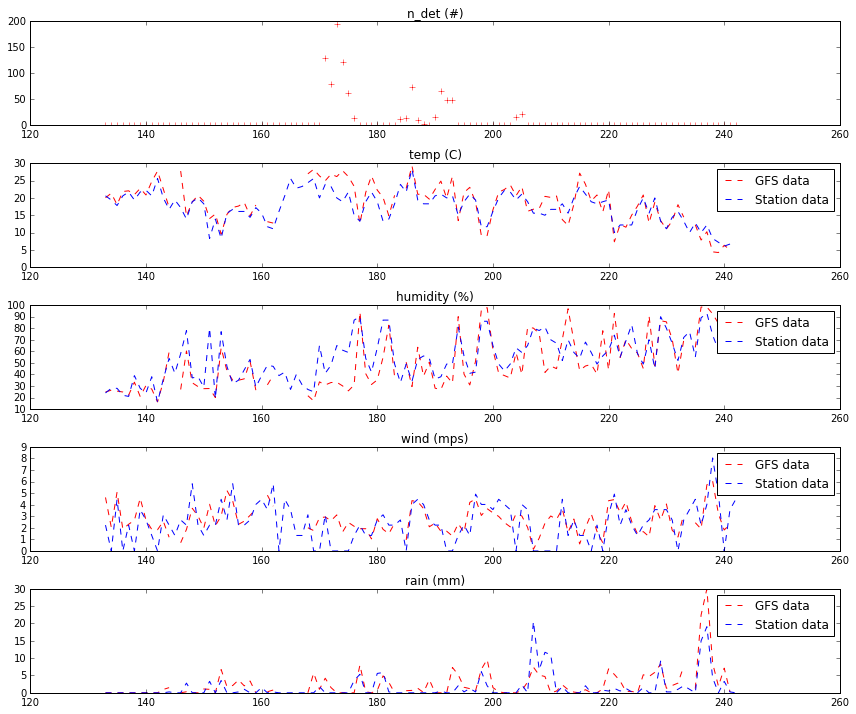

In [7]:
from util.daymonth import day2monthday
def get_covar_dict(fire_dict, df1, df2, year, date_range, myvars):
    dayofyear = date_range[0]
    ret_dict = dict()
    for var in myvars:
        if var == "n_det":
            ret_dict["n_det"] = []
        else:
            ret_dict[var + "1"] = []
            ret_dict[var + "2"] = []
    while dayofyear <= date_range[1]:
        month,day = day2monthday(dayofyear, year % 4 == 0)
        df1_row = df1[(df1.year==year) & (df1.month==month) & (df1.day==day)]
        df2_row = df2[(df2.year==year) & (df2.month==month) & (df2.day==day)]
        for var in myvars:
            if var == "n_det":
                ret_dict["n_det"].append(len(fire_dict[(fire_dict.year == year) & (fire_dict.day == day) & 
                                                       (fire_dict.month == month)]))
            else:
                if len(df1_row):
                    ret_dict[var + "1"].append(float(df1_row[var]))
                else:
                    ret_dict[var + "1"].append(np.nan)
                if len(df2_row):
                    ret_dict[var + "2"].append(float(df2_row[var]))
                else:
                    ret_dict[var + "2"].append(np.nan)
        dayofyear += 1
        
    for var in ret_dict.keys():
        ret_dict[var] = np.array(ret_dict[var])
    return ret_dict

# Covar plot
dist = 75
fb_fires = modis[(np.abs(modis.x - fb_x) < dist) & (np.abs(modis.y - fb_y) < dist)]
year = 2015
fire_season = (133,242)
season_days = np.arange(fire_season[0], fire_season[1]+1)
myvars = ['n_det', 'temp', 'humidity', 'wind', 'rain']
units = ['#', 'C', '%', 'mps', 'mm']
covar_dict = get_covar_dict(fb_fires, fb_gfs, fb_station, year, fire_season, myvars)
covar_dict["temp1"] -= 273.15
covar_dict["wind2"] *= 0.44704
covar_dict["rain2"] *= 25.4

fig, axes = plt.subplots(nrows=len(myvars), ncols=1, figsize=(12,10))
for i, var in enumerate(myvars):
    if not i:
        ax = plt.subplot(511 + i)
        ax1 = ax
    else:
        ax = plt.subplot(511 + i, sharex=ax1)

    if var == 'n_det':
        plt.plot(season_days, covar_dict["n_det"], "r+")
    else:
        plt.plot(season_days, covar_dict[var + "1"], "r--", label="GFS data")
        plt.plot(season_days, covar_dict[var + "2"], "b--", label="Station data")
        plt.legend()
    plt.title("%s (%s)" % (var, units[i]))
fig.tight_layout()
plt.savefig("pics/station_vs_gfs_covar_2013.png")
plt.show()


In [7]:
lat,lon = fairbanks_lat_lon
print fairbanks_lat_lon[1] % 360
lats = gfs_dict['lats']
lons = gfs_dict['lons']
lat_res = lats[0,0] - lats[1,0]
lon_res = lons[0,1] - lons[0,0]
row = int(float(lats[0,0] - lat) / lat_res)
positive_lon = lon % 360   # convert longitude to a positive value, which is what GFS uses
col = int(float(positive_lon - lons[0,0]) / lon_res)
print "min lon: %d, max lon: %d" % (lons[0,0], lons[-1,-1])
print "row: %d, col: %d" % (row,col)
print "lat: %d, lon: %d" % (lats[row,0], lons[0,col])

212.1239
min lon: 195, max lon: 221
row: 11, col: 33
lat: 65, lon: 212


In [8]:
from carpentry.get_gfs_and_modis_v2 import gfs_to_loc_df
gfs_to_loc_df(gfs_dict, lat, lon, outfi="data/weather/fb_gfs.pkl")

row,col: (11, 33)
lat/lon: (65.0, 212.0)


,day,dayofyear,humidity,month,rain,temp,valid_bits,vpd,wind,year
0,1,364,83.6,1,4.288216,268.70,4,0.072012,4.288216,2013
1,2,364,92.6,1,1.593800,260.30,4,0.016816,1.593800,2013
2,3,364,79.6,1,2.494013,263.90,4,0.061846,2.494013,2013
3,4,364,82.8,1,1.257179,260.50,4,0.039727,1.257179,2013
4,5,364,85.5,1,3.140143,261.00,4,0.034876,3.140143,2013
5,6,364,92.0,1,2.386504,263.30,4,0.023130,2.386504,2013
6,7,364,94.2,1,2.510478,258.60,4,0.011466,2.510478,2013
7,8,364,95.8,1,0.986560,255.60,4,0.006459,0.986560,2013
8,9,364,99.8,1,1.970913,253.10,4,0.000248,1.970913,2013
9,10,364,97.3,1,1.174436,260.80,4,0.006390,1.174436,2013


In [15]:
print np.all(gfs_dict['rain'] == gfs_dict['wind'])


True
